In [1]:
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
import ndlib.models.CompositeModel as gc
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
from pymongo import MongoClient
import numpy as np
from ndlibCustom.SEIR_ASModel import SEIR_ASModel
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import scipy.stats as st

In [2]:
from pymongo import MongoClient
import networkx as nx
import numpy as np
import sys

def keyPresent(keys,word):
    for i in keys:
        if (i == word):
            return True
    return False

def generateFamilyClique(fam):
    fam_graph = nx.Graph()
    for mem in fam["members"]:
        fam_graph.add_node(mem["uuid"])
    G = (nx.complete_graph(list(fam_graph.nodes())))
    return G

def generateClassClique(cl):
    class_graph = nx.Graph()
    for alunno in cl["alunni"]:
        class_graph.add_node(alunno)
    G = (nx.complete_graph(list(class_graph.nodes())))
    return G

client = MongoClient('localhost', 27017)
db = client['tesi']
db_sezioni = db['sezioni']
db_infanzia = db['scuole_infanzia']
db_elementari = db['scuole_elementari']
db_medie = db['scuole_medie']
db_superiori = db['scuole_superiori']

graph = nx.Graph()
print("Loading database into memory...")
sez = list(db_sezioni.find())
max_sez = max([i["properties"]["SEZ"] for i in sez])

print("Creating nodes and family layers edges...")
for i in sez:
    print("Current section:",i["properties"]["SEZ"],"/",max_sez, end="\r", flush=True)
    if (keyPresent(i.keys(),"famiglie") == True):
        for fam in i["famiglie"]:\
            #print("Composing graph:",i["famiglie"].index(fam))
            #graph = nx.compose(graph, generateFamilyClique(fam))
            #print("graph composed")
            generated_graph = generateFamilyClique(fam)
            graph.add_nodes_from(generated_graph.nodes())
            graph.add_edges_from(generated_graph.edges())
            if (len(list(generated_graph.edges()))) != 0:
                for e in list(generated_graph.edges()):
                    graph.edges[e]['weight'] = 1
            for mem in fam["members"]:
                graph.nodes[mem["uuid"]]['age'] = mem["age"]
                graph.nodes[mem["uuid"]]['family_id'] = fam["family_id"]
                #print(nx.get_edge_attributes(graph,'weight'))
            

print("Creating scuole_infanzia layer edges...")
school_size = len(list(db_infanzia.find()))
for i in list(db_infanzia.find()):
    #print("Current school:",list(db_infanzia.find()).index(i),"/",school_size, end="\r", flush=True)
    for classe in i["classi"]:
        generated_graph = generateClassClique(classe)
        graph.add_edges_from(generated_graph.edges())
        if (len(list(generated_graph.edges()))) != 0:
            for e in list(generated_graph.edges()):
                graph.edges[e]['weight'] = np.random.random_sample()
            #print(nx.get_edge_attributes(graph,'weight'))

print("Creating scuole_elementari layer edges...")
school_size = len(list(db_elementari.find()))
for i in list(db_elementari.find()):
    print("Current school:",list(db_elementari.find()).index(i),"/",school_size, end="\r", flush=True)
    for classe in i["classi"]:
        generated_graph = generateClassClique(classe)
        graph.add_edges_from(generated_graph.edges())
        if (len(list(generated_graph.edges()))) != 0:
            for e in list(generated_graph.edges()):
                graph.edges[e]['weight'] = np.random.random_sample()
            #print(nx.get_edge_attributes(graph,'weight'))

print("Creating scuole_media layer edges...")
school_size = len(list(db_medie.find()))
for i in list(db_medie.find()):
    print("Current school:",list(db_medie.find()).index(i),"/",school_size, end="\r", flush=True)
    for classe in i["classi"]:
        generated_graph = generateClassClique(classe)
        graph.add_edges_from(generated_graph.edges())
        if (len(list(generated_graph.edges()))) != 0:
            for e in list(generated_graph.edges()):
                graph.edges[e]['weight'] = np.random.random_sample()
            #print(nx.get_edge_attributes(graph,'weight'))

print("Creating scuole_superiori layer edges...")
school_size = len(list(db_superiori.find()))
for i in list(db_superiori.find()):
    print("Current school:",list(db_superiori.find()).index(i),"/",school_size, end="\r", flush=True)
    for classe in i["classi"]:
        generated_graph = generateClassClique(classe)
        graph.add_edges_from(generated_graph.edges())
        if (len(list(generated_graph.edges()))) != 0:
            for e in list(generated_graph.edges()):
                graph.edges[e]['weight'] = np.random.random_sample()
            #print(nx.get_edge_attributes(graph,'weight'))

print("Creating workplace layer edges...")
for i in sez:
    print("Current section:",i["properties"]["SEZ"],"/",max_sez, end="\r", flush=True)
    if (keyPresent(i.keys(),"lavoratori") == True):
        g = nx.erdos_renyi_graph(len(i["lavoratori"]),0.15)
        mapped = {}
        for index in range(0,len(i["lavoratori"])):
            mapped[list(g.nodes())[index]] = i["lavoratori"][index]
        g_2 = nx.relabel_nodes(g, mapped)
        graph.add_edges_from(g_2.edges())
        if (len(list(g_2.edges()))) != 0:
            for e in list(g_2.edges()):
                graph.edges[e]['weight'] = np.random.random_sample()
            #print(nx.get_edge_attributes(graph,'weight'))

        #for lavoratore in i["lavoratori"]:
        #    for lavoratore_next in i["lavoratori"]:
        #        if (np.random.binomial(1, 0.1) == 1):
        #            if (graph.has_edge(lavoratore,lavoratore_next) == False and lavoratore != lavoratore_next):graph.add_edge(lavoratore,lavoratore_next)

#Cleanup unneeded local variables
del(db_elementari)
del(db_infanzia)
del(db_medie)
del(db_superiori)
del(db_sezioni)
del(sez)
del(classe)
del(g)
del(g_2)
del(generated_graph)
del(mapped)
del(max_sez)
del(school_size)
del(index)
del(fam)
del(i)

#Graph should already be free of self loops
print("Removing self edges...")
graph.remove_edges_from(nx.selfloop_edges(graph))

#Graph should already be undirected
#print("Converting to undirected graph...")
#graph = nx.convert_node_labels_to_integers(graph.to_undirected())

print("total nodes:",len(graph.nodes()))
print("total edges:",len(graph.edges()))

#This turns UUIDs to sequential IDs
relabeled = nx.convert_node_labels_to_integers(graph)
del(graph)

#print("Generating GraphML...")
#nx.write_gml(relabeled, "dataset.gml")
#print("Generating adjacency list...")
#nx.write_adjlist(relabeled, "dataset.adjlist")
#print("Generating GPickle graph...")
#nx.write_gpickle(relabeled, "Datasets/dataset.gpickle")

print("Done.")

Loading database into memory...
Creating nodes and family layers edges...
Creating scuole_infanzia layer edges...
Creating scuole_elementari layer edges...
Creating scuole_media layer edges...
Creating scuole_superiori layer edges...
Creating workplace layer edges...
Removing self edges...
total nodes: 1230056
total edges: 9040334
Done.


In [2]:
#G = nx.read_gpickle('Datasets/dataset.gpickle')
#relabeled = nx.convert_node_labels_to_integers(G)
#del(G)
#print(len(relabeled.nodes()))
#print(len(relabeled.edges()))

1230056
9039501


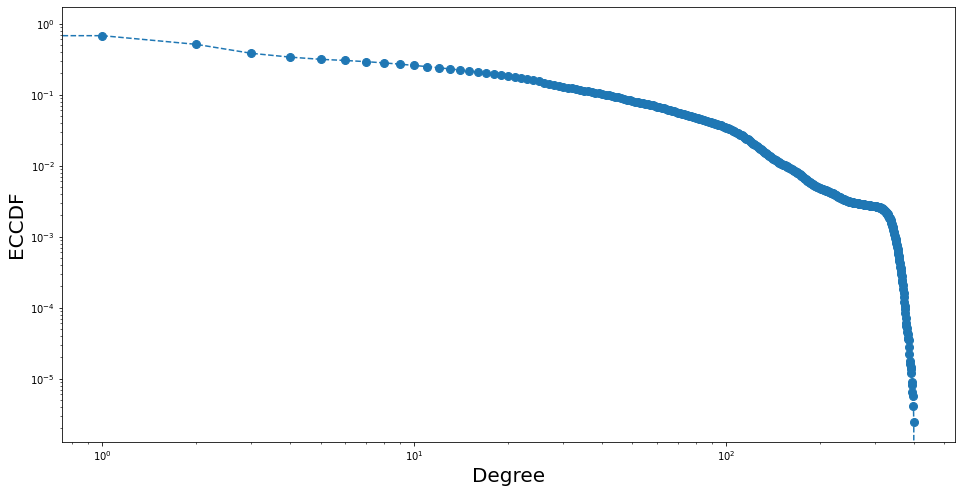

In [3]:
density = nx.density(relabeled)
degree = list(dict(relabeled.degree()).values())
#ECCDF in loglog scale
cdf = ECDF(degree)
x = np.unique(degree)
y = cdf(x)
fig_cdf = plt.figure(figsize=(16,8))
axes = fig_cdf.gca()
axes.loglog(x,1-y,marker='o',ms=8, linestyle='--')
axes.set_xlabel('Degree',size=20)
axes.set_ylabel('ECCDF', size=20)
plt.show()
print(np.mean(degree))
print(density)

In [4]:
Gcc = sorted(nx.connected_components(relabeled), key=len, reverse=True)
G0 = relabeled.subgraph(Gcc[0])
G1 = relabeled.subgraph(Gcc[1])
print(len(G0))
print(len(G1))

782471
200


In [5]:
agedistrib_g1 = []
a1 = 0
a2 = 0
a3 = 0
for i in relabeled.nodes():
    if relabeled.nodes[i]['age'] == '65+':
        a3 += 1
    elif relabeled.nodes[i]['age'] == '20-64':
        a2 += 1
    else: 
        a1 +=1
print("Disribuzione di età su grafo totale")
print("Giovani:",a1,"Attivi:",a2,"Anziani:",a3)
print()
g1 = a1
g2 = a2
g3 = a3
for i in G0.nodes():
    if G0.nodes[i]['age'] == '65+':
        a3 -= 1
    elif G0.nodes[i]['age'] == '20-64':
        a2 -= 1
    else: 
        a1 -=1
print("Disribuzione di età fuori dalla Giant Component (in percentuale sul totale)")
print("Giovani:",a1,"(",round((a1/g1)*100,3),")","Attivi:",a2,"(",round((a2/g2)*100,3),")","Anziani:",a3,"(",round((a3/g3)*100,3),")")
print()
print("Nodi appartenenti alla Giant Component")
print("Giovani:",g1-a1,"Attivi:",g2-a2,"Anziani:",g3-a3)

Disribuzione di età su grafo totale
Giovani: 204096 Attivi: 720817 Anziani: 305143

Disribuzione di età fuori dalla Giant Component (in percentuale sul totale)
Giovani: 8771 ( 4.297 ) Attivi: 147118 ( 20.41 ) Anziani: 291696 ( 95.593 )

Nodi appartenenti alla Giant Component
Giovani: 195325 Attivi: 573699 Anziani: 13447


Mean percentual of workers for sez: 49.5462388676737


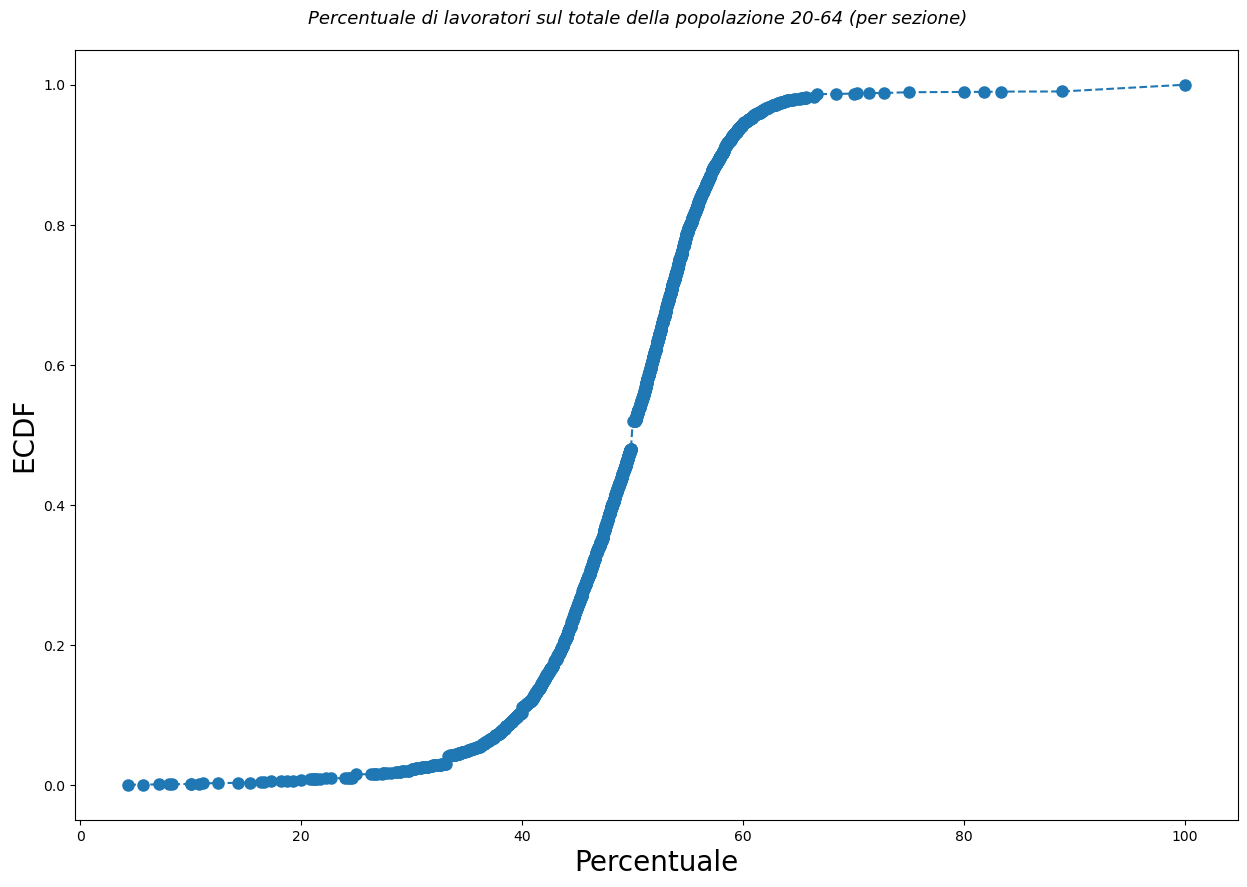

In [6]:
client = MongoClient('localhost', 27017)
db = client['tesi']
db_sezioni = db['sezioni']
db_lavoro = db['lavoro']

work_dist = []
for i in list(db_sezioni.find()):
    #print("Indexing sez:",i["properties"]["SEZ"], end="\r", flush=True)
    num_attivi = 0
    num_workers = 0
    if "famiglie" in i.keys():
        for fam in i["famiglie"]:
            for mem in fam["members"]:
                if mem["age"] == "20-64": 
                    num_attivi += 1
                    if "sez_lavoro" in mem.keys(): num_workers += 1
        if (num_workers != 0 and num_attivi != 0):
            work_dist.append({"sez":i["properties"]["SEZ"],"num":(num_workers/num_attivi)*100})

list_dist =  [i["num"] for i in work_dist]
print("Mean percentual of workers for sez:",np.mean(list_dist))

# ECDF linear scale
plt.style.use('default')
cdf = ECDF(list_dist)
x = np.unique(list_dist)
y = cdf(x)
fig_cdf = plt.figure(figsize=(15,10))
axes = fig_cdf.gca()
axes.plot(x,y,marker='o',ms=8,  linestyle='--')
# general title
plt.suptitle('Percentuale di lavoratori sul totale della popolazione 20-64 (per sezione)', fontsize=13, fontweight=0, color='black', style='italic', y=0.92)
axes.set_xlabel('Percentuale',size=20)
axes.set_ylabel('ECDF', size = 20)
plt.show()

In [14]:
#CUSTOM SEIR_AS MODEL SIMULATION
print("Simulating...")
# Model selection
model = SEIR_ASModel(relabeled)

# Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.57) #Infection rate from I_A/S Neighbors
cfg.add_model_parameter('gamma', 0.15) #Recovery/Removal rate
cfg.add_model_parameter('alpha', 0.2) #Latent period
cfg.add_model_parameter('kappa', 0.25) #Symptomatic/Asymptomatic Ratio

#This parameter "smoothens" out the infection rate in the first iterations.
#1: 1-(1-beta)^(num_of_infected_neighbors)[0.99 on > 5 infected neighbors]
#0: beta*(average_infected_weight)
cfg.add_model_parameter('tp_rate', 0)

cfg.add_model_parameter("fraction_infected", 0.005) #Starting infected nodes
model.set_initial_status(cfg)

#Run 50 simulations, results will be a mean of all data generated
simulations = []
for i in range (0,50):
    print("Running simulation number",i+1)
    lastsim = model.iteration_bunch(60,progress_bar=True)
    for i in lastsim:
        i.pop('node_count')
        i.pop('status_delta')
        i.pop('iteration')
    simulations.append(lastsim)
    model.reset()

Simulating...
  3%|▎         | 2/60 [00:11<05:31,  5.72s/it]


KeyboardInterrupt: 

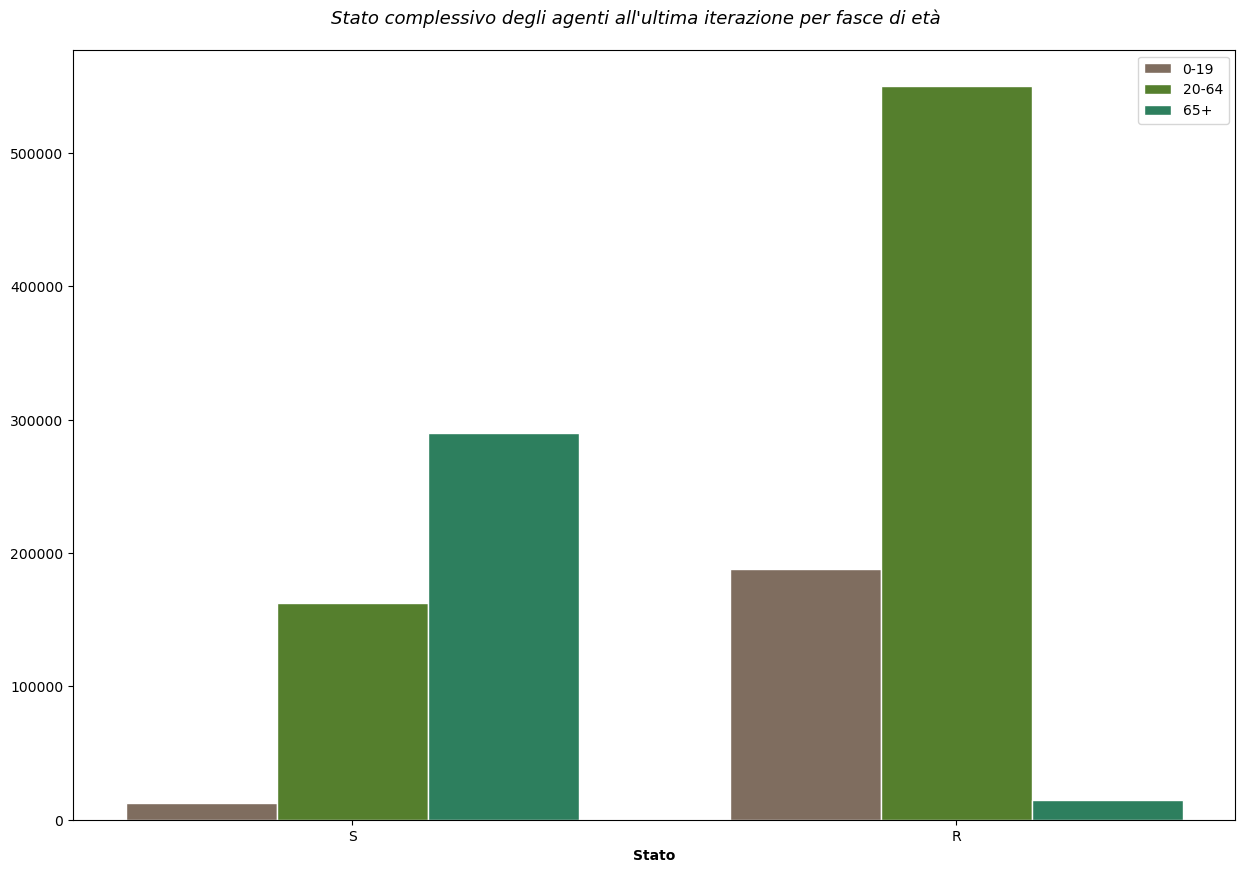


Mean values
[12713.98, 188297.62] [162443.18, 550081.22] [289953.04, 14938.76]

CI 95%
Giovani (S): (12664.303019824607, 12763.656980175392)
Giovani (R): (188244.8907674019, 188350.3492325981)
Attivi (S): (162253.64527121512, 162632.71472878486)
Attivi (R): (549877.5821375819, 550284.857862418)
Anziani (S): (289928.8977742395, 289977.1822257605)
Anziani (R): (14914.92563893708, 14962.59436106292)


In [8]:
#Create complete status map by dymanically rebuilding infection iteration results
#Keys are nodes, values are final statuses
#Look for keys in graph to get attributes
s_giovani = []
r_giovani = []
s_attivi = []
r_attivi = []
s_anziani = []
r_anziani = []

for iteration in simulations:
    graph_stat = {}
    for x in iteration[0]['status']:
        graph_stat[x] = iteration[0]['status'][x]
    for iter in iteration:
        for s in iter['status']:
            graph_stat[s] = iter['status'][s]    

    stats_giovani = {0:[],1:[],2:[],3:[],4:[],5:[]}
    stats_attivi = {0:[],1:[],2:[],3:[],4:[],5:[]}
    stats_anziani = {0:[],1:[],2:[],3:[],4:[],5:[]}
    for i in graph_stat:
        if relabeled.nodes[i]['age'] == '65+':
            stats_anziani[graph_stat[i]].append(i)
        elif relabeled.nodes[i]['age'] == '20-64':
            stats_attivi[graph_stat[i]].append(i)
        else:
            stats_giovani[graph_stat[i]].append(i)
            
    giovani_p = []
    attivi_p = []
    anziani_p = []
    for i in stats_giovani:
        giovani_p.append(len(stats_giovani[i]))
        attivi_p.append(len(stats_attivi[i]))
        anziani_p.append(len(stats_anziani[i]))
    
    #Build mean for CI(95%)
    s_giovani.append(giovani_p[0])
    r_giovani.append(giovani_p[5])
    s_attivi.append(attivi_p[0])
    r_attivi.append(attivi_p[5])
    s_anziani.append(anziani_p[0])
    r_anziani.append(anziani_p[5])

giovani_p = [np.mean(s_giovani),np.mean(r_giovani)]
attivi_p = [np.mean(s_attivi),np.mean(r_attivi)]
anziani_p = [np.mean(s_anziani),np.mean(r_anziani)]

plt.rcParams['figure.figsize'] = [15, 10]

# set width of bar
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(giovani_p))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, giovani_p, color='#7f6d5f', width=barWidth, edgecolor='white', label='0-19')
plt.bar(r2, attivi_p, color='#557f2d', width=barWidth, edgecolor='white', label='20-64')
plt.bar(r3, anziani_p, color='#2d7f5e', width=barWidth, edgecolor='white', label='65+')

# Add xticks on the middle of the group bars
# general title
plt.suptitle("Stato complessivo degli agenti all'ultima iterazione per fasce di età", fontsize=13, fontweight=0, color='black', style='italic', y=0.92)
plt.xlabel('Stato', fontweight='bold')
labels = ['S',"R"]
plt.xticks([r + barWidth for r in range(len(giovani_p))], labels)
 
# Create legend & Show graphic
plt.legend()
plt.show()
print()
print("Mean values")
print(giovani_p,attivi_p,anziani_p)
print()
print("CI 95%")
print("Giovani (S):",st.t.interval(alpha=0.95, df=len(s_giovani)-1, loc=np.mean(s_giovani), scale=st.sem(s_giovani)))
print("Giovani (R):",st.t.interval(alpha=0.95, df=len(r_giovani)-1, loc=np.mean(r_giovani), scale=st.sem(r_giovani)))
print("Attivi (S):",st.t.interval(alpha=0.95, df=len(s_attivi)-1, loc=np.mean(s_attivi), scale=st.sem(s_attivi)))
print("Attivi (R):",st.t.interval(alpha=0.95, df=len(r_attivi)-1, loc=np.mean(r_attivi), scale=st.sem(r_attivi)))
print("Anziani (S):",st.t.interval(alpha=0.95, df=len(s_anziani)-1, loc=np.mean(s_anziani), scale=st.sem(s_anziani)))
print("Anziani (R):",st.t.interval(alpha=0.95, df=len(r_anziani)-1, loc=np.mean(r_anziani), scale=st.sem(r_anziani)))

In [9]:
#Check if herd immunity has ben achieved inside the giant component G0
G0_susceptible = []
G0_neighbors = []
G0_neighbors_s = []
G0_neighbors_r = []

for iteration in simulations:
    nodelist = []
    neighbors = {}
    graph_stat = {}
    neighbors_s = {}
    neighbors_r = {}
    #Rebuild current iteration status tree
    for x in iteration[0]['status']:
        graph_stat[x] = iteration[0]['status'][x]
    for iter in iteration:
        for s in iter['status']:
            graph_stat[s] = iter['status'][s]   
    #Cycle through nodes
    for i in G0.nodes():
        if i in graph_stat.keys():
            #Process selected S_Nodes
            if graph_stat[i] == 0:
                nodelist.append(i)
                neighborhood = [n for n in relabeled.neighbors(i)]
                neighbors_s[i] = []
                neighbors_r[i] = []
                sum = 0
                sus = 0
                rem = 0
                for n in neighborhood:
                    neighbors[n] = graph_stat[n]
                    sum += 1
                    if graph_stat[n] == 0: sus += 1
                    if graph_stat[n] == 5: rem += 1
                neighbors_s[i].append(int((sus/sum)*100))
                neighbors_r[i].append(int((rem/sum)*100))
    
    G0_susceptible.append(len(nodelist))
    G0_neighbors.append(neighbors)
    G0_neighbors_s.append(neighbors_s)
    G0_neighbors_r.append(neighbors_r)

    
neighbors_s = [n[0] for n in neighbors_s.values()]
neighbors_r = [n[0] for n in neighbors_r.values()]
print("Nodi in stato S all'ultima iterazione:",np.mean(G0_susceptible))
print("CI 95%",st.t.interval(alpha=0.95, df=len(G0_susceptible)-1, loc=np.mean(G0_susceptible), scale=st.sem(G0_susceptible)))
print()

print("Numero di neighbors dei nodi con stato S all'ultima iterazione:",np.mean([len(n) for n in G0_neighbors]))
print("CI 95%",st.t.interval(alpha=0.95, df=len([len(n) for n in G0_neighbors])-1, loc=np.mean([len(n) for n in G0_neighbors]), scale=st.sem([len(n) for n in G0_neighbors])))
print()

G0_NS = []
G0_NIE = []
G0_NR = []
for iteration_neighbors in G0_neighbors:
    NS = 0
    NIE = 0
    NR = 0
    for i in iteration_neighbors:
        if iteration_neighbors[i] == 0: NS += 1
        elif iteration_neighbors[i] == 5: NR += 1
        else: NIE +=1
    G0_NS.append(NS)
    G0_NIE.append(NIE)
    G0_NR.append(NR)
        
print("S:",np.mean(G0_NS),"R:",np.mean(G0_NR),"EAS/IAS:",np.mean(G0_NIE))
print("CI 95%")
print("S",st.t.interval(alpha=0.95, df=len(G0_NS)-1, loc=np.mean(G0_NS), scale=st.sem(G0_NS)))
print("R",st.t.interval(alpha=0.95, df=len(G0_NR)-1, loc=np.mean(G0_NR), scale=st.sem(G0_NR)))
print("EAS/IAS",st.t.interval(alpha=0.95, df=len(G0_NIE)-1, loc=np.mean(G0_NIE), scale=st.sem(G0_NIE)))

Nodi in stato S all'ultima iterazione: 29300.2
CI 95% (29169.16864993931, 29431.23135006069)

Numero di neighbors dei nodi con stato S all'ultima iterazione: 41477.2
CI 95% (41314.1989166111, 41640.20108338889)

S: 20725.7 R: 19766.68 EAS/IAS: 984.82
CI 95%
S (20596.90011206694, 20854.49988793306)
R (19695.555254596085, 19837.804745403915)
EAS/IAS (967.9529812687889, 1001.6870187312112)


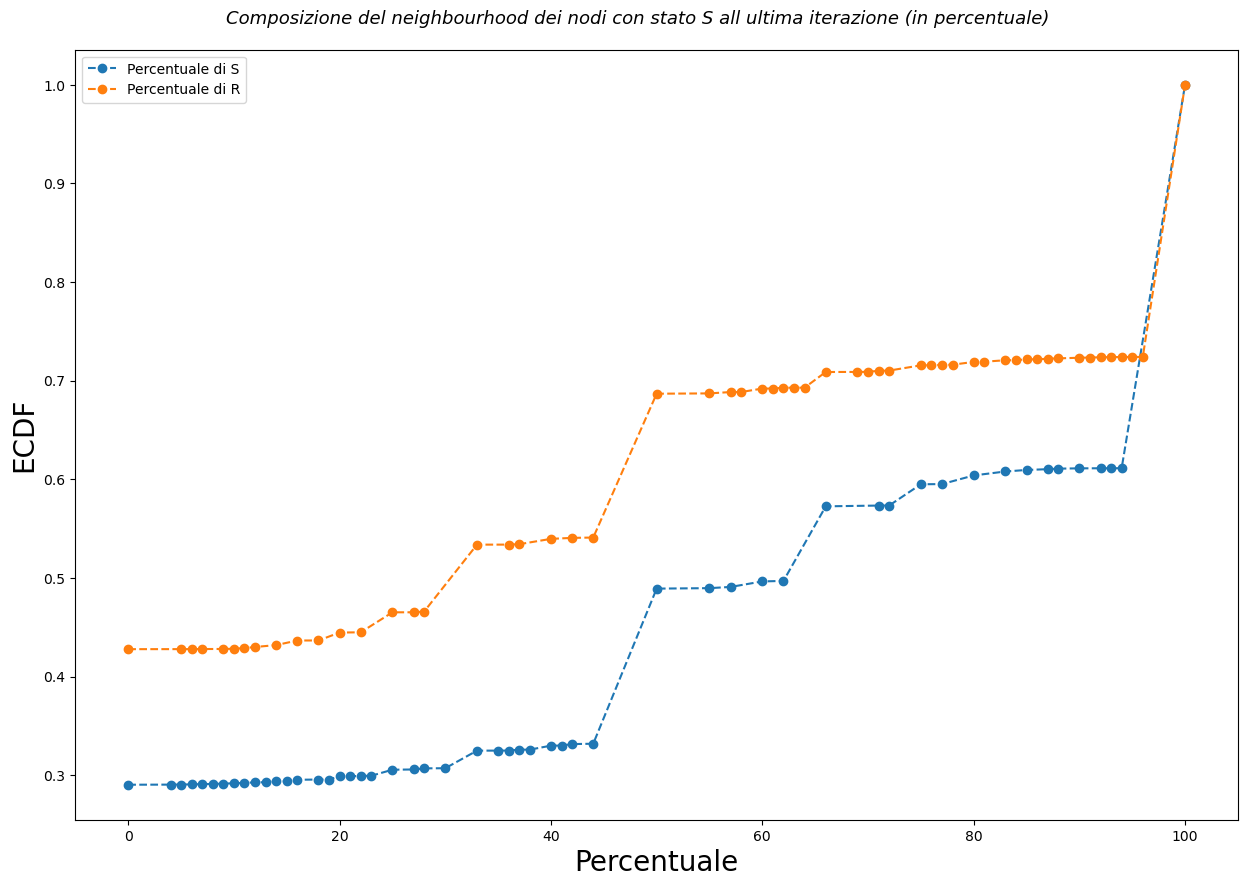

In [10]:
#TODO: Find out how the fuck this is plotted

# ECDF linear scale
plt.style.use('default')
cdf = ECDF(neighbors_s)
x = np.unique(neighbors_s)
y = cdf(x)
fig_cdf = plt.figure(figsize=(15,10))
axes = fig_cdf.gca()
axes.plot(x,y,marker='o',ms=6, linestyle='--', label='Percentuale di S')
cdf = ECDF(neighbors_r)
x = np.unique(neighbors_r)
y = cdf(x)
axes.plot(x,y,marker='o',ms=6, linestyle='--', label='Percentuale di R')
# general title
plt.suptitle('Composizione del neighbourhood dei nodi con stato S all ultima iterazione (in percentuale)', fontsize=13, fontweight=0, color='black', style='italic', y=0.92)
axes.set_xlabel('Percentuale',size=20)
axes.set_ylabel('ECDF', size = 20)
axes.legend()
plt.show()

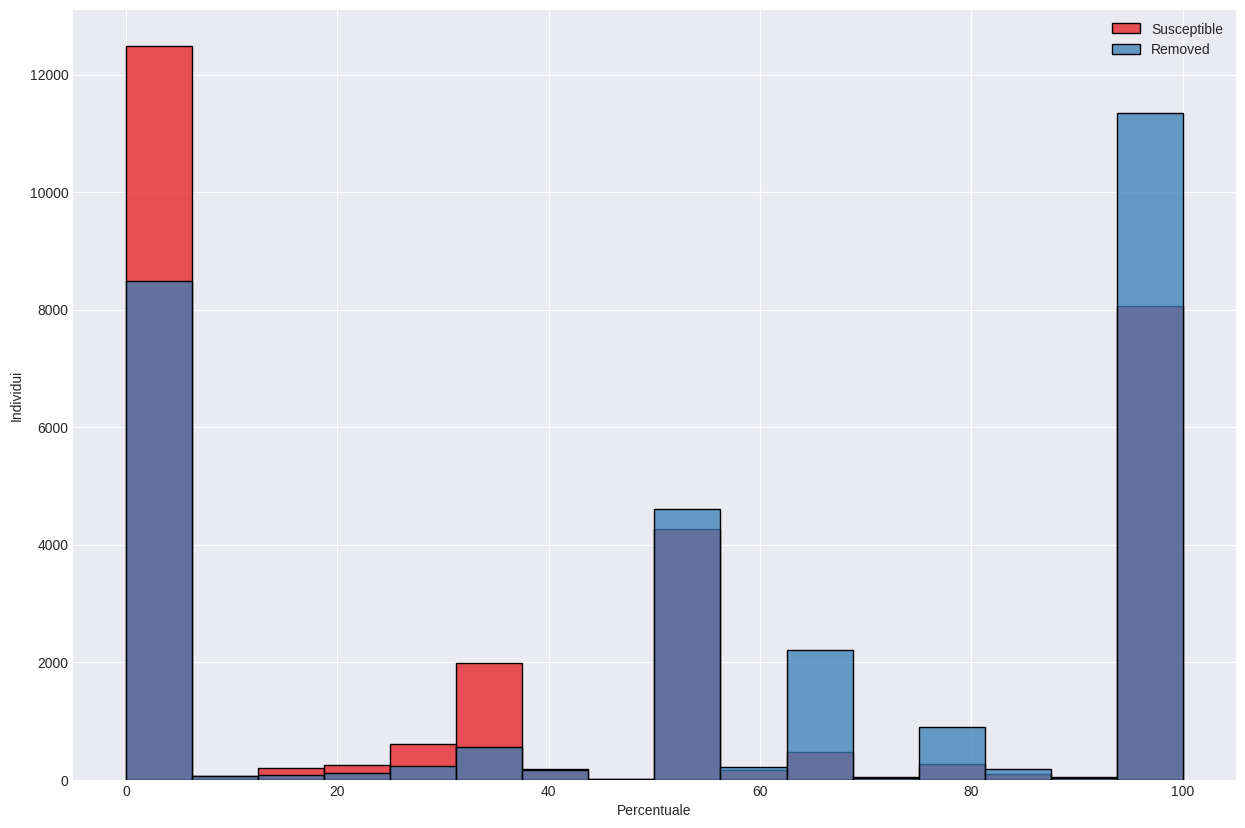

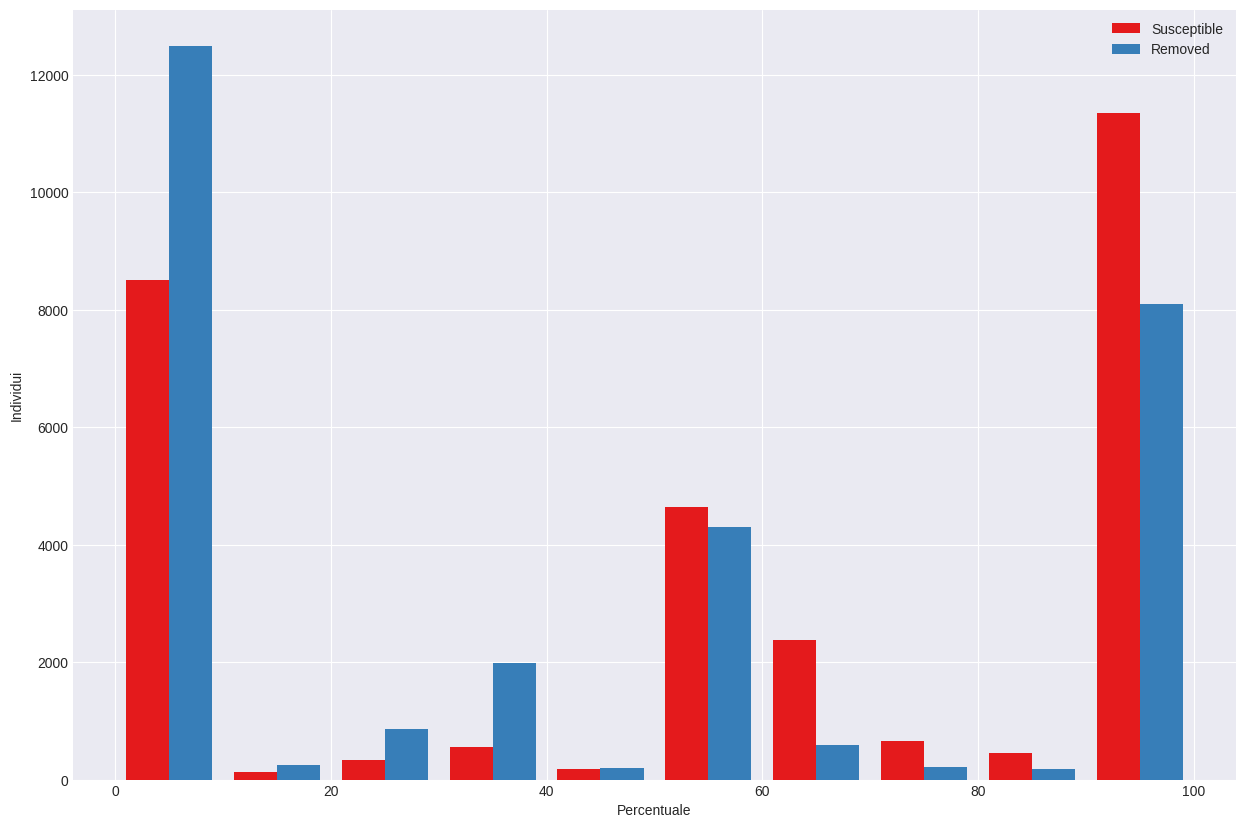

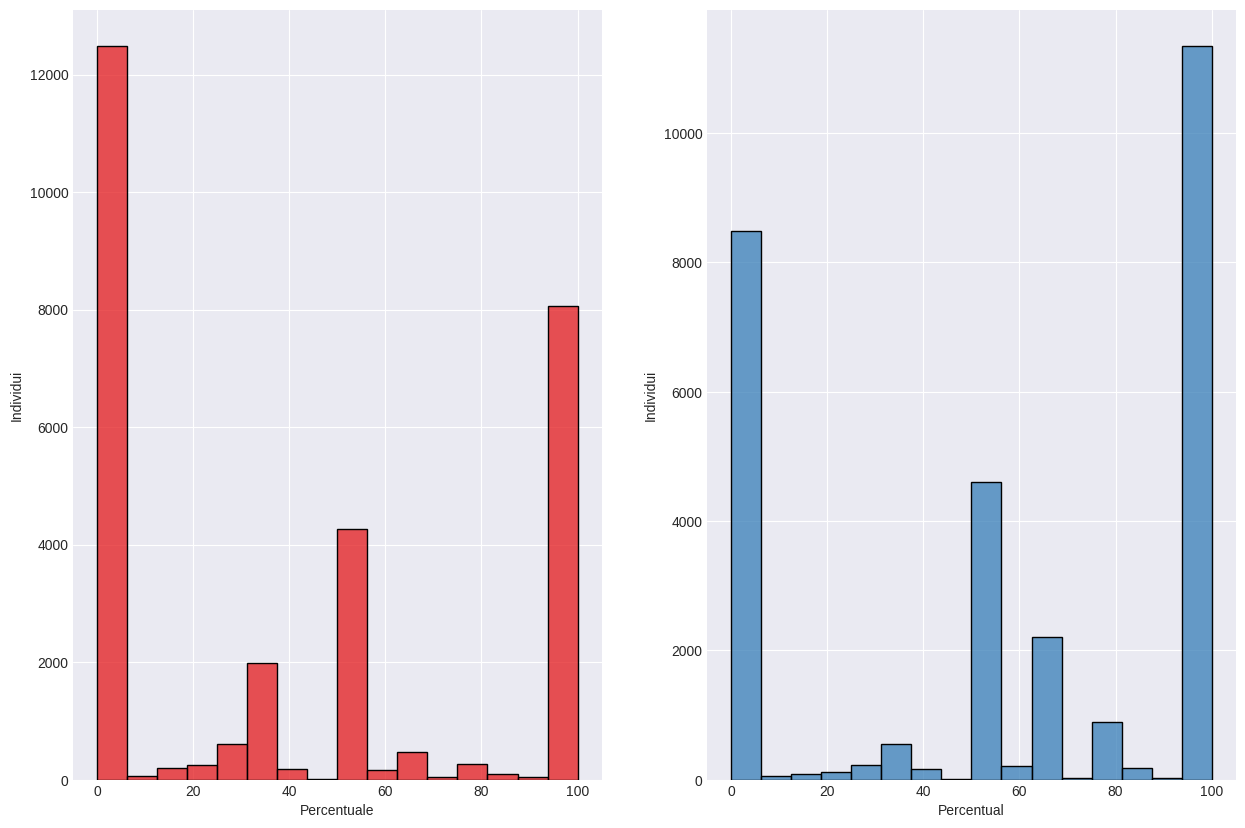

In [11]:
df=pd.DataFrame({'S':neighbors_s,'R':neighbors_r})

#Style
palette = plt.get_cmap('Set1')
plt.style.use('seaborn-darkgrid')

#Hist only
plt.figure(figsize=(15,10))
s = sns.histplot(df["R"], kde=False, color=palette(0), label="Susceptible")
r = sns.histplot(df["S"], kde=False, color=palette(1), label="Removed")
s.set(xlabel='Percentuale', ylabel='Individui')
plt.legend()
plt.show()

plt.figure(figsize=(15,10))
plt.hist([df["S"], df["R"]], color=[palette(0),palette(1)], label=["Susceptible","Removed"])
plt.legend()
plt.xlabel("Percentuale")
plt.ylabel("Individui")
plt.show()


f, axes = plt.subplots(1, 2, figsize=(15, 10), sharex=True)
s = sns.histplot(df["R"], ax=axes[0], color=palette(0))
r = sns.histplot(df["S"], ax=axes[1], color=palette(1))
s.set(xlabel='Percentuale', ylabel='Individui')
r.set(xlabel='Percentual', ylabel='Individui')
plt.show()

In [12]:
sim_giovani_a = []
sim_giovani_s = []
sim_attivi_a = []
sim_attivi_s = []
sim_anziani_a = []
sim_anziani_s = []

CI_giovani_a = {}
CI_giovani_s = {}
CI_attivi_a = {}
CI_attivi_s = {}
CI_anziani_a = {}
CI_anziani_s = {}

for iteration in simulations:
    graph_stat = {}
    giovani_a = {}
    giovani_s = {}
    attivi_a = {}
    attivi_s = {}
    anziani_a = {}
    anziani_s = {}
    for i in iteration[0]['status']:
        graph_stat[i] = iteration[0]['status'][i]
        
    #Rebuild simulations by age and status evolution
    for iter in iteration:
        inc_1a = 0
        inc_1s = 0
        inc_2a = 0
        inc_2s = 0
        inc_3a = 0
        inc_3s = 0
        for s in iter['status']:
            if graph_stat[s] == 0 or graph_stat[s] == 1 or graph_stat[s] == 2:
                if iter['status'][s] == 3:
                    if relabeled.nodes[s]['age'] == '20-64':
                        inc_2a += 1
                    elif relabeled.nodes[s]['age'] == '65+':
                        inc_3a += 1
                    else: 
                        inc_1a += 1
                elif iter['status'][s] == 4:
                    if relabeled.nodes[s]['age'] == '20-64':
                        inc_2s += 1
                    elif relabeled.nodes[s]['age'] == '65+':
                        inc_3s += 1
                    else: 
                        inc_1s += 1
        giovani_a[iter['iteration']] = inc_1a
        giovani_s[iter['iteration']] = inc_1s
        attivi_a[iter['iteration']] = inc_2a
        attivi_s[iter['iteration']] = inc_2s
        anziani_a[iter['iteration']] = inc_3a
        anziani_s[iter['iteration']] = inc_3s
    
    #Store values of each simulation
    sim_giovani_a.append(giovani_a)
    sim_giovani_s.append(giovani_s)
    sim_attivi_a.append(attivi_a)
    sim_attivi_s.append(attivi_s)
    sim_anziani_a.append(anziani_a)
    sim_anziani_s.append(anziani_s)
    
#Calculate mean values of each class
for i in range(0,len(sim_giovani_a[0])):
    values = []
    for index in range (0,len(sim_giovani_a)):
        values.append(sim_giovani_a[index][i])
    giovani_a[i] = np.mean(values)
    CI_giovani_a[i] = st.t.interval(alpha=0.95, df=len(values)-1, loc=np.mean(values), scale=st.sem(values))
    if np.isnan(CI_giovani_a[i][0]) == True and np.isnan(CI_giovani_a[i][1]) == True: CI_giovani_a[i] = (0,0)
    
for i in range(0,len(sim_giovani_s[0])):
    values = []
    for index in range (0,len(sim_giovani_s)):
        values.append(sim_giovani_s[index][i])
    giovani_s[i] = np.mean(values)
    CI_giovani_s[i] = st.t.interval(alpha=0.95, df=len(values)-1, loc=np.mean(values), scale=st.sem(values))
    if np.isnan(CI_giovani_s[i][0]) == True and np.isnan(CI_giovani_s[i][1]) == True: CI_giovani_s[i] = (0,0)
        
for i in range(0,len(sim_attivi_a[0])):
    values = []
    for index in range (0,len(sim_attivi_a)):
        values.append(sim_attivi_a[index][i])
    attivi_a[i] = np.mean(values)
    CI_attivi_a[i] = st.t.interval(alpha=0.95, df=len(values)-1, loc=np.mean(values), scale=st.sem(values))
    if np.isnan(CI_attivi_a[i][0]) == True and np.isnan(CI_attivi_a[i][1]) == True: CI_attivi_a[i] = (0,0)

for i in range(0,len(sim_attivi_s[0])):
    values = []
    for index in range (0,len(sim_attivi_s)):
        values.append(sim_attivi_s[index][i])
    attivi_s[i] = np.mean(values)
    CI_attivi_s[i] = st.t.interval(alpha=0.95, df=len(values)-1, loc=np.mean(values), scale=st.sem(values))
    if np.isnan(CI_attivi_s[i][0]) == True and np.isnan(CI_attivi_s[i][1]) == True: CI_attivi_s[i] = (0,0)

for i in range(0,len(sim_anziani_a[0])):
    values = []
    for index in range (0,len(sim_anziani_a)):
        values.append(sim_anziani_a[index][i])
    anziani_a[i] = np.mean(values)
    CI_anziani_a[i] = st.t.interval(alpha=0.95, df=len(values)-1, loc=np.mean(values), scale=st.sem(values))
    if np.isnan(CI_anziani_a[i][0]) == True and np.isnan(CI_anziani_a[i][1]) == True: CI_anziani_a[i] = (0,0)

for i in range(0,len(sim_anziani_s[0])):
    values = []
    for index in range (0,len(sim_anziani_s)):
        values.append(sim_anziani_s[index][i])
    anziani_s[i] = np.mean(values)
    CI_anziani_s[i] = st.t.interval(alpha=0.95, df=len(values)-1, loc=np.mean(values), scale=st.sem(values))
    if np.isnan(CI_anziani_s[i][0]) == True and np.isnan(CI_anziani_s[i][1]) == True: CI_anziani_s[i] = (0,0)
        
# Make a data frame
dataframes = []
dataframes.append(pd.DataFrame({'x': range(1,len(simulations[0])+1),'Giovani Asintomatici':list(giovani_a.values()),
                 'CI bottom':[CI_giovani_a[i][0] for i in CI_giovani_a],
                 'CI top':[CI_giovani_a[i][1] for i in CI_giovani_a]}))
# Make a data frame
dataframes.append(pd.DataFrame({'x': range(1,len(simulations[0])+1),'Giovani Sintomatici':list(giovani_s.values()),
                 'CI bottom':[CI_giovani_s[i][0] for i in CI_giovani_s],
                 'CI top':[CI_giovani_s[i][1] for i in CI_giovani_s]}))
# Make a data frame
dataframes.append(pd.DataFrame({'x': range(1,len(simulations[0])+1),'Attivi Asintomatici':list(attivi_a.values()),
                 'CI bottom':[CI_attivi_a[i][0] for i in CI_attivi_a],
                 'CI top':[CI_attivi_a[i][1] for i in CI_attivi_a]}))
# Make a data frame
dataframes.append(pd.DataFrame({'x': range(1,len(simulations[0])+1),'Attivi Sintomatici':list(attivi_s.values()),
                 'CI bottom':[CI_attivi_s[i][0] for i in CI_attivi_s],
                 'CI top':[CI_attivi_s[i][1] for i in CI_attivi_s]}))
# Make a data frame
dataframes.append(pd.DataFrame({'x': range(1,len(simulations[0])+1),'Anziani Asintomatici':list(anziani_a.values()),
                 'CI bottom':[CI_anziani_a[i][0] for i in CI_anziani_a],
                 'CI top':[CI_anziani_a[i][1] for i in CI_anziani_a]}))
# Make a data frame
dataframes.append(pd.DataFrame({'x': range(1,len(simulations[0])+1),'Anziani Sintomatici':list(anziani_s.values()),
                 'CI bottom':[CI_anziani_s[i][0] for i in CI_anziani_s],
                 'CI top':[CI_anziani_s[i][1] for i in CI_anziani_s]}))

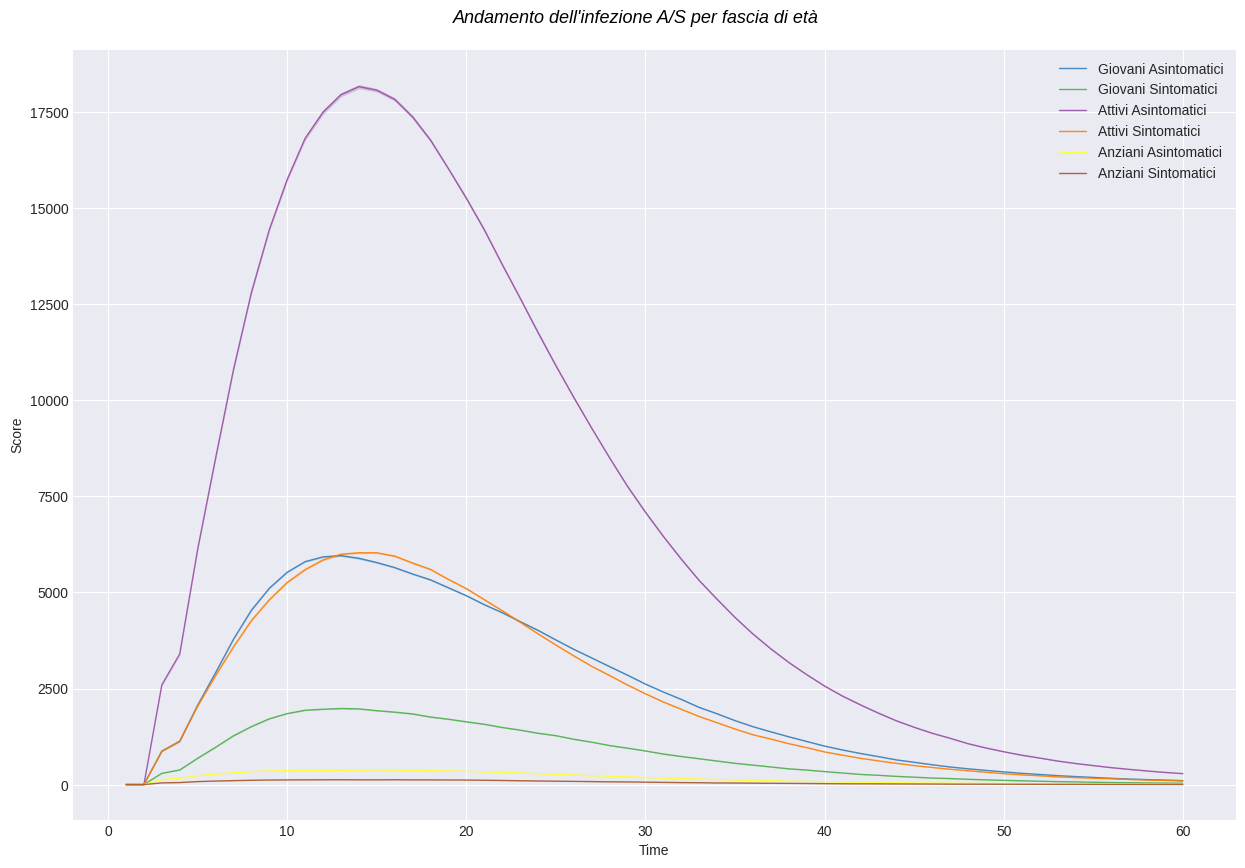

In [31]:
# style
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(15,10))
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num = 0
for df in dataframes:
    num += 1
    for column in df.drop('x', axis=1):
        if column != 'CI bottom' and column != 'CI top':
            plt.plot(df['x'], df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)
            plt.plot(df['x'], df['CI bottom'], marker='', color=palette(num), linewidth=0, alpha=0)
            plt.plot(df['x'], df['CI top'], marker='', color=palette(num), linewidth=0, alpha=0)
            plt.fill_between(df['x'], df['CI bottom'], df['CI top'], color=palette(num), alpha=0.3, linewidth=0)
                                                             

#Add legend
plt.legend()

# general title
plt.suptitle("Andamento dell'infezione A/S per fascia di età", fontsize=13, fontweight=0, color='black', style='italic', y=0.92)
    
#Add titles
plt.xlabel("Time")
plt.ylabel("Score")
plt.show()

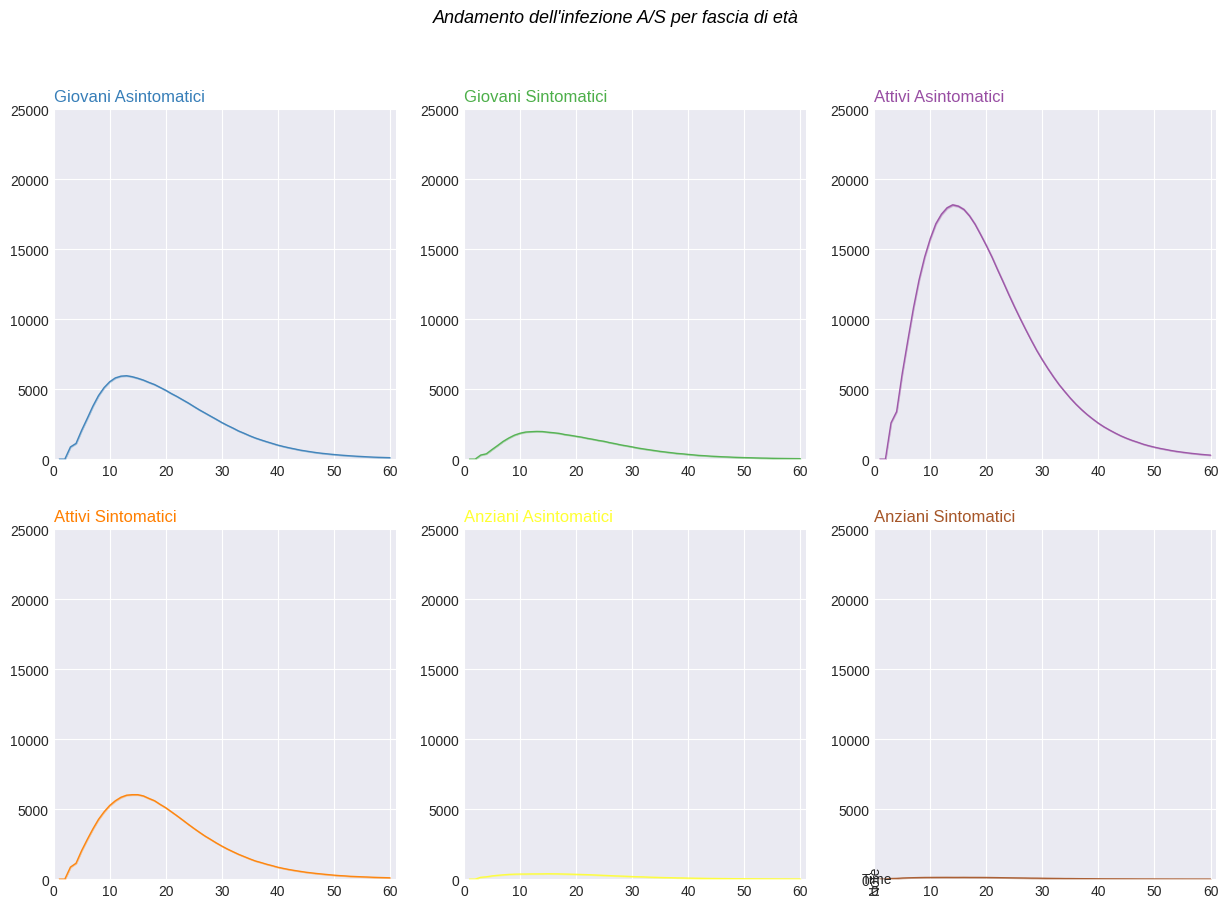

In [27]:
# Initialize the figure
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(15,10))

# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot

num = 0
for df in dataframes:
    num += 1
    for column in df.drop('x', axis=1):
        if column != 'CI bottom' and column != 'CI top':
            plt.subplot(2,3, num)
            plt.plot(df['x'], df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)
            plt.plot(df['x'], df['CI bottom'], marker='', color=palette(num), linewidth=0, alpha=0)
            plt.plot(df['x'], df['CI top'], marker='', color=palette(num), linewidth=0, alpha=0)
            plt.fill_between(df['x'], df['CI bottom'], df['CI top'], color=palette(num), alpha=0.3)
            
            # Same limits for everybody!
            plt.xlim(0,61)
            plt.ylim(0,25000)
        
            # Not ticks everywhere
            if num in range(7) :
                plt.tick_params(labelbottom='off')
            if num not in [1,4,7] :
                plt.tick_params(labelleft='off')

            # Add title
            plt.title(column, loc='left', fontsize=12, fontweight=0, color=palette(num))
            
# general title
plt.suptitle("Andamento dell'infezione A/S per fascia di età", fontsize=13, fontweight=0, color='black', style='italic', y=0.98)
 
# Axis title
plt.text(0.5, 0.02, 'Time', ha='center', va='center')
plt.text(0.06, 0.5, 'Note', ha='center', va='center', rotation='vertical')
plt.show()